# Домашнее задание №8

### 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции:

$$y = \frac{\sin(x)}{x}-\frac{x}{10}$$

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю




In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

torch.manual_seed(42)
rng = np.random.default_rng(42)
%config InlineBackend.figure_formats = ['svg']  # Для более четкого графика

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


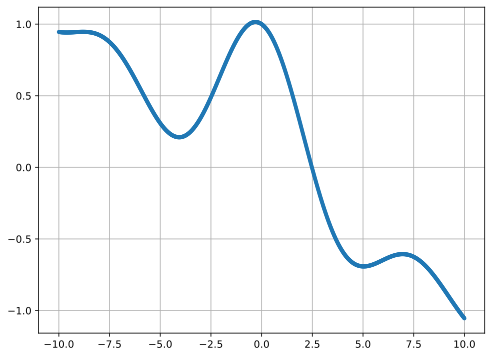

In [2]:
#Сгенерируем настоящие данные
train_data_length = 1024
start = -10
stop = 10
train_data = torch.zeros((train_data_length, 2))
x = np.linspace(start, stop, train_data_length)
np.random.shuffle(x)
train_data[:, 0] = torch.tensor(x, dtype=torch.float)
train_data[:, 1] = (torch.sin(train_data[:, 0])/train_data[:, 0])-(train_data[:, 0]/10)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

plt.figure(figsize=(8,6))
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.grid() 
plt.show()  

Создание модели

In [3]:
# Генератор:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 16),
                                   nn.Sigmoid(),
                                   nn.Linear(16, 32),
                                   nn.Sigmoid(),
                                   nn.Linear(32, 64),
                                   nn.Sigmoid(),
                                   nn.Linear(64, 2))

    def forward(self, x):
        output = self.model(x)
        return output


# Дискриминатор:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(2, 128),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(128, 64),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(64, 1),                                  
                                   nn.Sigmoid())
  

    def forward(self, img):
        validity = self.model(img)
        return validity

Обучение

In [4]:
# Инициализация:
n_epochs = 1000 # количество эпох
lr = 0.0006 # шаг обучения

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)  # Без гиперпараметров b1 и b2 лучше
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)  # Без гиперпараметров b1 и b2 лучше

# Но вот функция ошибки у нас будет одна общая
loss_function = torch.nn.BCELoss()

In [5]:
losses_G = []
losses_D = []

for epoch in tqdm(range(n_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        latent_space_samples = torch.randn((batch_size, 2)).to(device)
        generated_samples = generator(latent_space_samples).to(device)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)
        all_samples = torch.cat((real_samples, generated_samples)).to(device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)).to(device)

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_D.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2)).to(device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_G.step()
        losses_G.append(loss_generator.detach().cpu()), losses_D.append(loss_discriminator.detach().cpu())

        # Выводим значения функций потерь
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"\nEpoch: {epoch} Loss Discriminator: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss Generator: {loss_generator}")

  0%|                                                                                 | 1/1000 [00:01<24:31,  1.47s/it]


Epoch: 0 Loss Discriminator: 0.49759671092033386
Epoch: 0 Loss Generator: 0.7040356397628784


 10%|███████▉                                                                       | 101/1000 [00:24<03:27,  4.32it/s]


Epoch: 100 Loss Discriminator: 0.7353220582008362
Epoch: 100 Loss Generator: 1.068137526512146


 20%|███████████████▉                                                               | 201/1000 [00:47<03:05,  4.31it/s]


Epoch: 200 Loss Discriminator: 0.6957426071166992
Epoch: 200 Loss Generator: 0.667148768901825


 30%|███████████████████████▊                                                       | 301/1000 [01:11<02:42,  4.31it/s]


Epoch: 300 Loss Discriminator: 0.6900213956832886
Epoch: 300 Loss Generator: 0.6713898181915283


 40%|███████████████████████████████▋                                               | 401/1000 [01:34<02:19,  4.29it/s]


Epoch: 400 Loss Discriminator: 0.6960185766220093
Epoch: 400 Loss Generator: 0.703280508518219


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:57<01:56,  4.29it/s]


Epoch: 500 Loss Discriminator: 0.6944324374198914
Epoch: 500 Loss Generator: 0.7153075933456421


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:21<01:33,  4.25it/s]


Epoch: 600 Loss Discriminator: 0.7173144817352295
Epoch: 600 Loss Generator: 0.7104557752609253


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [02:44<01:09,  4.30it/s]


Epoch: 700 Loss Discriminator: 0.6908497214317322
Epoch: 700 Loss Generator: 0.6924927234649658


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:08<00:46,  4.27it/s]


Epoch: 800 Loss Discriminator: 0.6906690001487732
Epoch: 800 Loss Generator: 0.719468355178833


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [03:31<00:22,  4.31it/s]


Epoch: 900 Loss Discriminator: 0.6963507533073425
Epoch: 900 Loss Generator: 0.6878015995025635


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:54<00:00,  4.26it/s]


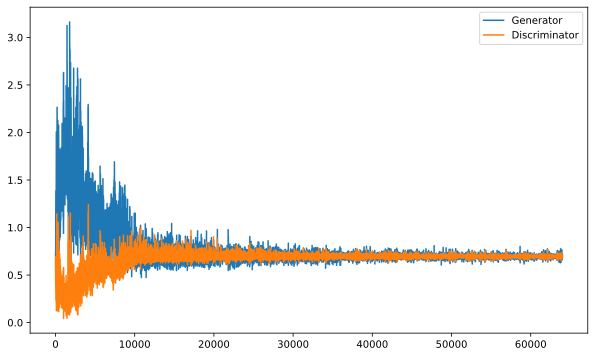

In [6]:
# Процесс обученя
plt.figure(figsize=(10, 6))
plt.plot(losses_G, label='Generator', )
plt.plot(losses_D, label='Discriminator', )
plt.legend()
plt.show() 

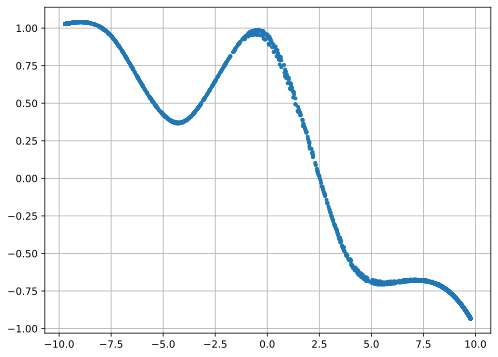

In [7]:
length = 10_000
x = np.linspace(start, stop, length)
np.random.shuffle(x)
latent_space_samples = torch.tensor(x.reshape((length // 2), 2), dtype=torch.float).to(device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach().cpu()


plt.figure(figsize=(8, 6))
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.grid() 
plt.show()  